In [1]:
%matplotlib inline

In [2]:
import sys
!conda install -c conda-forge --yes --prefix {sys.prefix} geoplot geopandas imageio pysal cartopy==0.18 geos proj mapclassify

Solving environment: done

# All requested packages already installed.



In [21]:
import geoplot as gplt
import geopandas as gpd
import imageio
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import shapely
from shapely import ops, affinity
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import MultiPolygon, LineString, MultiLineString
import geopy as gp
import geopy.distance
from labellines import labelLine, labelLines
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
import cartopy as ctp
import matplotlib.ticker as mticker
import itertools
from geographiclib.geodesic import Geodesic
import fiona

In [14]:
ctp.config['pre_existing_data_dir'] = '/usr/local/Caskroom/miniconda/base/pkgs/cartopy_offlinedata-0.2.3-pyh9f0ad1d_0/share/cartopy'

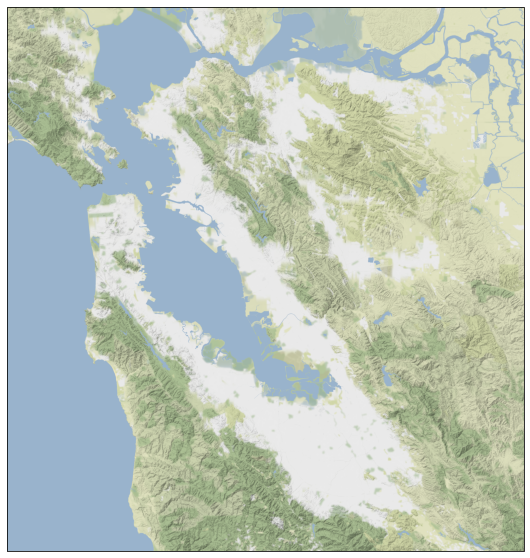

In [20]:
stamen_terrain = cimgt.Stamen('terrain-background')
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

# Set range of map, stipulate zoom level
ax.set_extent([-122.7, -121.5, 37.15, 38.15], crs=ccrs.Geodetic())
ax.add_image(stamen_terrain, 12)

ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='10m', facecolor='none'), edgecolor='gray')

In [50]:
popdem = gpd.read_file('assets/Tract_2010Census_DP1/Tract_2010Census_DP1.shp')
projection = stamen_terrain.crs
ax.add_geometries(popdem.geometry,
                  projection,
                  edgecolor='k',zorder=0)

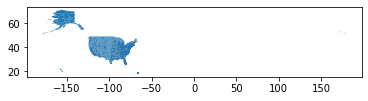

In [64]:
popdem.geometry.plot()

In [289]:
ncc_sf = gp.Point(37.7929223,-122.4074297)

def _run_census_get(_coords, popdem):
    coords = gpd.GeoDataFrame(geometry = _coords, crs=popdem.crs)
    tracts_data = gpd.sjoin(coords, popdem)[["geometry","index_right","NAMELSAD10","INTPTLAT10","INTPTLON10","DP0010001"]]
    tracts_included = tracts_data.index_right.drop_duplicates().to_list()
    tract_pop = np.asarray([[a, popdem.iloc[a]["DP0010001"]] for a in tracts_included])
    tract = tract_pop[np.where(tract_pop[:,1]==np.amax(tract_pop[:,1]))[0]][0][0]
    tract_center = shapely.geometry.Point([float(a) for a in popdem.iloc[tract][["INTPTLAT10","INTPTLON10"]].to_list()])
    return tract_center

def guess_by_population(point, radiusmiles, popdem, second_choice=False):
    d = gp.distance.distance(miles = radiusmiles)
    degs = np.arange(0,360,1)
    circle = [tuple(d.destination(point=point, bearing=a)) for a in degs]
    poly_circ = LineString(circle)
    _coords = [shapely.geometry.Point(a) for a in np.fliplr(np.asarray(poly_circ.coords.xy).T)]
    
    tract_center = _run_census_get(_coords, popdem)
    endpt = ops.nearest_points(tract_center,poly_circ)[1]
    
    if not second_choice:
        return endpt
    
    else:
        bearing = Geodesic.WGS84.Inverse(point.latitude, point.longitude, *endpt.xy[0], *endpt.xy[1])["azi1"]
        degs = np.arange(0,360-20,1)
        degs = np.round((degs+bearing+10)%360,2)
        circle = [tuple(d.destination(point=point, bearing=a)) for a in degs]
        circ_frag = LineString(circle)
        _coords = [shapely.geometry.Point(a) for a in np.fliplr(np.asarray(poly_circ.coords.xy).T)]
        t2 = _run_census_get(_coords, popdem)
        t2 = ops.nearest_points(t2,circ_frag)[1]
        return endpt, t2

In [285]:
b = guess_by_population(ncc_sf, 10, popdem, second_choice=True)
[a.xy for a in b]

[(array('d', [37.920685809131406]), array('d', [-122.3209738107997])),
 (array('d', [37.906828396621364]), array('d', [-122.29428762280405]))]

In [288]:
test = triangulate.plotter()

NameError: name 'triangulate' is not defined